# Network Anomaly Detection 
## 03. Model training

In this notebook, we will train and evaluate 4 baseline models: Logistic Regression, Random Forest, Decision Tree, K-Nearest Neighbors (KNN)


### 1. Setup

In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import joblib
sns.set(style="whitegrid")


### 2. Load processed data

In [67]:
X = np.load("../data/processed/X.npy")
y = np.load("../data/processed/y.npy")

print("Loaded X shape:", X.shape)
print("Loaded y shape:", y.shape)

Loaded X shape: (3245180, 4)
Loaded y shape: (3245180,)


### 3. Split train/test data

In [68]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")
print(pd.Series(y_train).value_counts(normalize=True))

Training set: (2596144, 4), Test set: (649036, 4)
1    0.998606
0    0.001394
Name: proportion, dtype: float64


Resampling data

In [69]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)


### 4. Define models

In [70]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB()
}

### 5. Train and evaluate

In [71]:
results = []

for name, model in models.items():
    print(f"\n-- Training {name} ...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])
    except:
        auc = np.nan

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

    print(f"{name} done.")


-- Training Logistic Regression ...
Logistic Regression done.

-- Training Decision Tree ...
Decision Tree done.

-- Training Random Forest ...
Random Forest done.

-- Training Naive Bayes ...
Naive Bayes done.


### 6. Results

Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,TP,TN,FP,FN
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0,648131,905,0,0
1,Decision Tree,1.0,1.0,1.0,1.0,1.0,648131,905,0,0
2,Random Forest,1.0,1.0,1.0,1.0,1.0,648131,905,0,0
3,Naive Bayes,1.0,1.0,1.0,1.0,1.0,648131,905,0,0


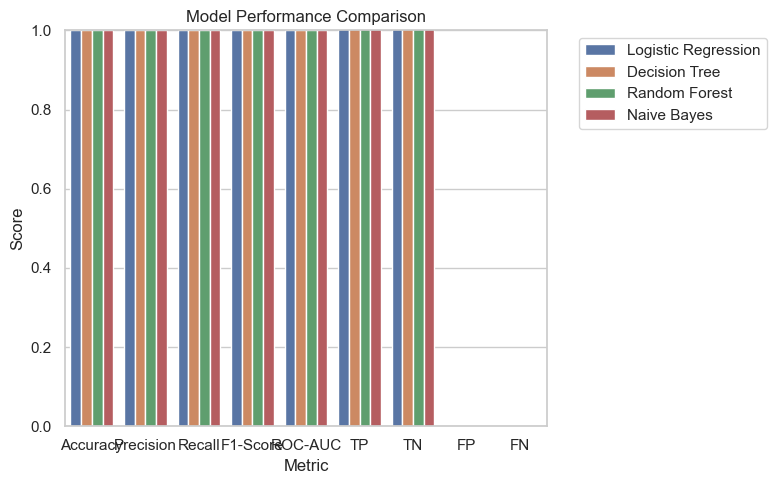

In [72]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("Model Comparison:")
display(results_df)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 7. Save models

In [73]:
os.makedirs("../models", exist_ok=True)
for name, model in models.items():
    filename = name.lower().replace(" ", "_") + ".pkl"
    path = os.path.join("../models", filename)
    joblib.dump(model, path)
    print(f"Saved {name} -> {path}")

Saved Logistic Regression -> ../models\logistic_regression.pkl
Saved Decision Tree -> ../models\decision_tree.pkl
Saved Random Forest -> ../models\random_forest.pkl
Saved Naive Bayes -> ../models\naive_bayes.pkl


### 8. Summary & Analysis